## Hypothesis Test Example

This notebook performs an hypothesis test and computes the significance of the test (p-value) using the asympotic approximation of the profile likelihood function.

The test statistics for computing the hypothesis test is 

$$q_\mu = - 2 \log \frac { L( x \ | \ \mu , \hat{\hat{\nu} } ) }{  L( x \ | \ \hat{\mu} , \hat{\nu}  ) } \  \  \ \mathrm{for} \  \  
\hat{\mu}  >  0$$
$$q_\mu = 0     \hspace{3cm}     \ \mathrm{for} \  \  
\hat{\mu} \le  0$$

The p-value (significance) of the test is computed assuming that $q_\mu$ is distributed according to a 1/2 $\chi^2$ distribution with 1 degree of freedom.



In [ ]:
//%jsroot on

In [1]:
using namespace RooStats;

In [2]:
RooPlot * plot = nullptr;
RooAbsPdf * pdf = nullptr;
HypoTestResult * result = nullptr;
// enable use of NLL offset for better minimizations
RooStats::UseNLLOffset(true);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



####  1. Reading the model (Workspace) from input file

First part is just to access the workspace file and retrieve the model and the data 

In [3]:
TString fileName ="HiggsBinModel.root";  
//TString fileName ="CountingModel.root";  
TString workspaceName = "w";
TString modelConfigName = "ModelConfig";
TString dataName = "data";
TString integrationType = "";  
//ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");

nexp_events = 250;  // number of expected events for the expected significance

In [4]:
auto file = TFile::Open(fileName);

In [5]:
auto w =  (RooWorkspace*) file->Get(workspaceName);
w->Print();
auto sbModel = (RooStats::ModelConfig*) w->obj(modelConfigName);
auto  data = w->data(dataName);
auto poi = (RooRealVar*) sbModel->GetParametersOfInterest()->first();


RooWorkspace(w) w contents

variables
---------
(a1,a2,mass,nbackground,nsignal,width,x)

p.d.f.s
-------
RooExponential::bmodel[ x=z c=1 ] = 0.000354025
RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350859
RooGaussian::smodel[ x=x mean=mass sigma=width ] = 1.8233e-12

functions
--------
RooFormulaVar::z[ actualVars=(a1,a2,x) formula="-(a1*x/100.+a2*(x/100.)^2)" ] = -7.94614

datasets
--------
RooDataHist::data(x)

named sets
----------
ModelConfig_NuisParams:(a1,a2,nbackground)
ModelConfig_Observables:(x)
ModelConfig_POI:(nsignal)
nuisParams:(a1,a2,nbackground)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



##### Make the b Model by cloning the b model and use a value = 0 for the parameter of interest

In [6]:
auto bModel = (RooStats::ModelConfig*) sbModel->Clone();
sbModel->SetName("S+B Model");
// save previous poi value
poiHat = poi->getVal(); 
poi->setVal(nexp_events);
sbModel->SetSnapshot( *poi);
bModel->SetName("B Model");
poi->setVal(0);
bModel->SetSnapshot( *poi  );
sbModel->Print();
bModel->Print();
// restore poi value to best fit value
poi->setVal(poiHat);


=== Using the following for S+B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000354025
Snapshot:                
  1) 0x124d79040 RooRealVar:: nsignal = 250 +/- 93.6477  L(0 - 1000)  "nsignal"


=== Using the following for B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000354025
Snapshot:                
  1) 0x124d79040 RooRealVar:: nsignal = 0 +/- 93.6477  L(0 - 1000)  "nsignal"



#### 2. Plot of the model pdf and the data 

we plot the pdf describing the model over the data. Since we have performed before a best fit, the pdf should have the parameters at their best fit values. 

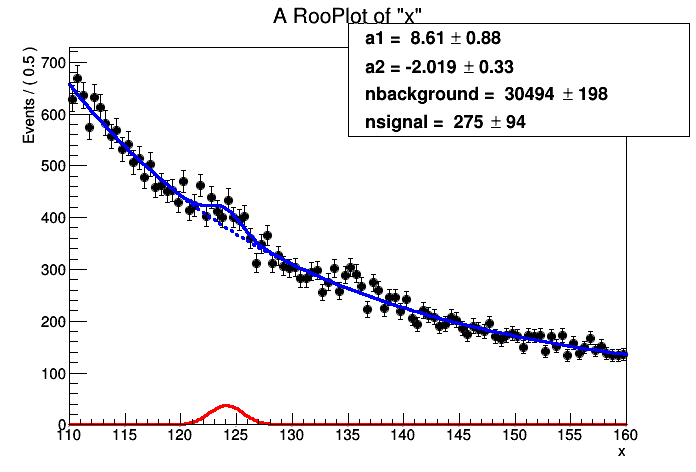

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bmodel)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: (z)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (smodel)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [7]:
plot = w->var("x")->frame();
pdf = sbModel->GetPdf();
data->plotOn(plot);
pdf->plotOn(plot);
pdf->plotOn(plot, RooFit::Components("bmodel"),RooFit::LineStyle(kDashed));
pdf->plotOn(plot, RooFit::Components("smodel"),RooFit::LineColor(kRed));
pdf->paramOn(plot);

plot->Draw();
gPad->Draw();

We assume we know the mass and the width of the peak, so we set it to constant.

We could eventually also set to constant the background parameters. In this case the systematic uncertainties due to the background shape will not be taken into account.

In [8]:
//w->var("a1")->setConstant(true);
//w->var("a2")->setConstant(true);
w->var("mass")->setConstant(true);
w->var("width")->setConstant(true);

In [9]:
// RooStats::AsymptoticCalculator::SetPrintLevel(-1);  // to switch off print level 
RooStats::AsymptoticCalculator  asymCalc(*data, *sbModel, *bModel);

[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize....
[#0] PROGRESS:Eval -- AsymptoticCalculator::Initialize - Find  best unconditional NLL on observed data
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a1           8.61176e+00  8.81605e-01   -5.00000e+02  5.00000e+02
     2 a2          -2.01906e+00  3.33556e-01   -5.00000e+02  5.00000e+02
     3 nbackground   3.04943e+04  1.97777e+02    3.07700e+03  3.07700e+05
     4 nsignal      2.75167e+02  9.36477e+01    0.00000e+00  1.00000e+03
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD        2000           1
 **********
 MIGRAD MINIMIZATION HAS CONVE

Configure the calculator

In [10]:
asymCalc.SetOneSidedDiscovery(true);  // for one-side discovery test
//asymCalc.SetPrintLevel(-1);  // to suppress print level 

Run the calculator and get the result

In [11]:
result = asymCalc.GetHypoTest();
result->Print();


[#1] INFO:Eval -- AsymptoticCalculator::GetHypoTest: - perform  an hypothesis test for  POI ( nsignal ) = 0
[#0] PROGRESS:Eval -- AsymptoticCalculator::GetHypoTest -  Find  best conditional NLL on OBSERVED data set ..... 
AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **   13 **SET PRINT           0
 **********
 **********
 **   14 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a1           8.61178e+00  9.90677e-01   -5.00000e+02  5.00000e+02
     2 a2          -2.01905e+00  3.74453e-01   -5.00000e+02  5.00000e+02
     3 nbackground   3.04947e+04  1.89190e+02    3.07700e+03  3.07700e+05
 **********
 **   15 **SET ERR         0.5
 **********
 **********
 **   16 **SET PRINT           0
 **********
 **********
 **   17 **SET STR           1
 **********
 **********
 **   18 **MIGRAD        1500           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRA

In [12]:
std::cout << "Significance = " << result->Significance() << " for p-value = " << result->NullPValue() << std::endl; 

Significance = 3.78679 for p-value = 7.63032e-05


#### Is Test statistic distribution like a chi-square distribution with n.d.f =1 ? 

We want to fit the null test statistic distribution to check if it is compatible with a chi2 distribution

Create the fit function as a 1/2 chisquared. Special case for forst bin (x < 0.05) 
Also the quantity plotted is the log-likelihood ratio and not 2 x log-likelihood ratio .
0.05 is the histogram bin width. 

In [13]:
auto fchi2 = new TF1("chi2","[](double*x,double*p){ if (x[0] < 0.05) { return 0.5*p[0]+ 0.5*p[0]*ROOT::Math::chisquared_cdf(0.1,p[1]); } else { return 0.05*p[0]*ROOT::Math::chisquared_pdf(x[0],p[1]); } }",0.,20.,2,1);

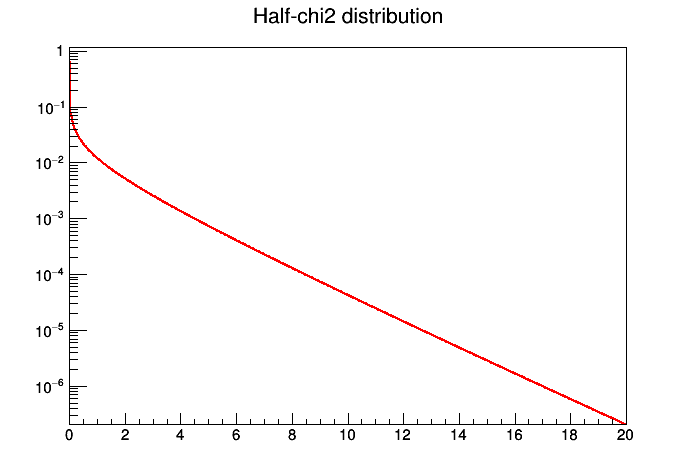

In [14]:
fchi2->SetParameters(1,1);
fchi2->SetNpx(1000);
fchi2->SetLineColor(kRed);
fchi2->Draw();
fchi2->SetTitle("Half-chi2 distribution");
gPad->SetLogy(true);
gPad->Draw();

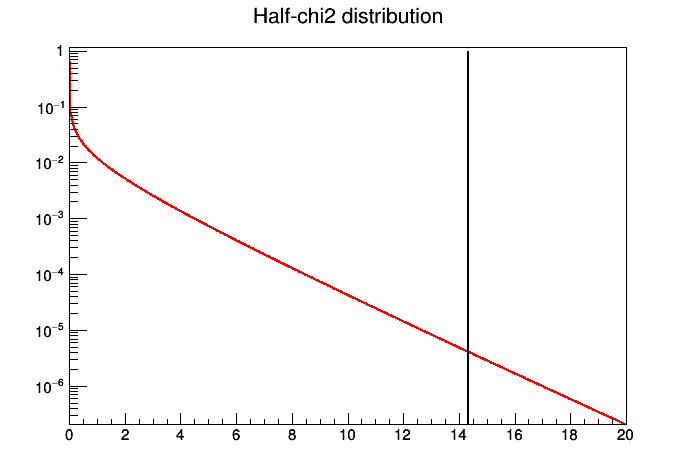

test statistic data value = 14.3398


In [15]:
// add data value
sqmu = ROOT::Math::normal_quantile_c(result->NullPValue(),1);
qmu = sqmu*sqmu; 
std::cout << "test statistic data value = " << qmu << std::endl;
dataLine = new TLine(qmu,fchi2->GetMinimum(),qmu,1.);
dataLine->SetLineWidth(2);
dataLine->Draw();
gPad->Draw();